In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [2]:
import pathlib
data_dir = pathlib.Path("D:\\pyhton codes\\affetcnet\\archive (2)\\affectnet_dataset")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

18332


In [3]:
os.path.abspath("D:\\pyhton codes\\affetcnet\\archive (2)\\affectnet_dataset")

'D:\\pyhton codes\\affetcnet\\archive (2)\\affectnet_dataset'

In [4]:
batch_size = 32
img_height = 224
img_width = 224


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 29042 files belonging to 8 classes.
Using 23234 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 29042 files belonging to 8 classes.
Using 5808 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 146
Number of test batches: 36


In [9]:
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
# performance tuning steps 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

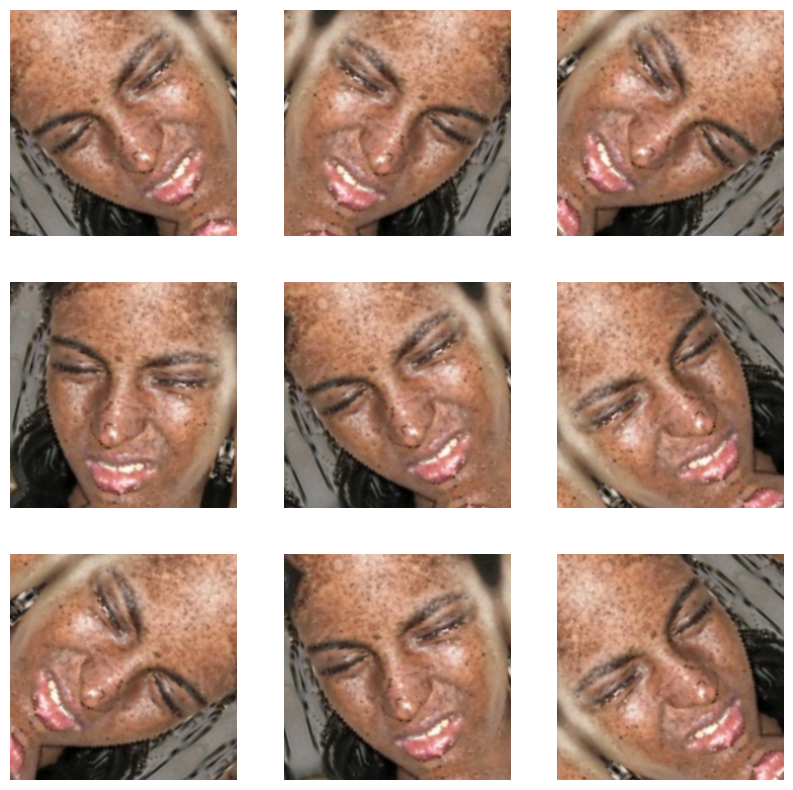

In [12]:
import matplotlib.pyplot as plt

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [14]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

if physical_devices:
  print("First GPU Device Name:", physical_devices[0].name)


Num GPUs Available: 1
First GPU Device Name: /physical_device:GPU:0


In [15]:
print(tf.__version__)


2.10.0


In [16]:
# class_names = train_ds.class_names
# print(class_names)

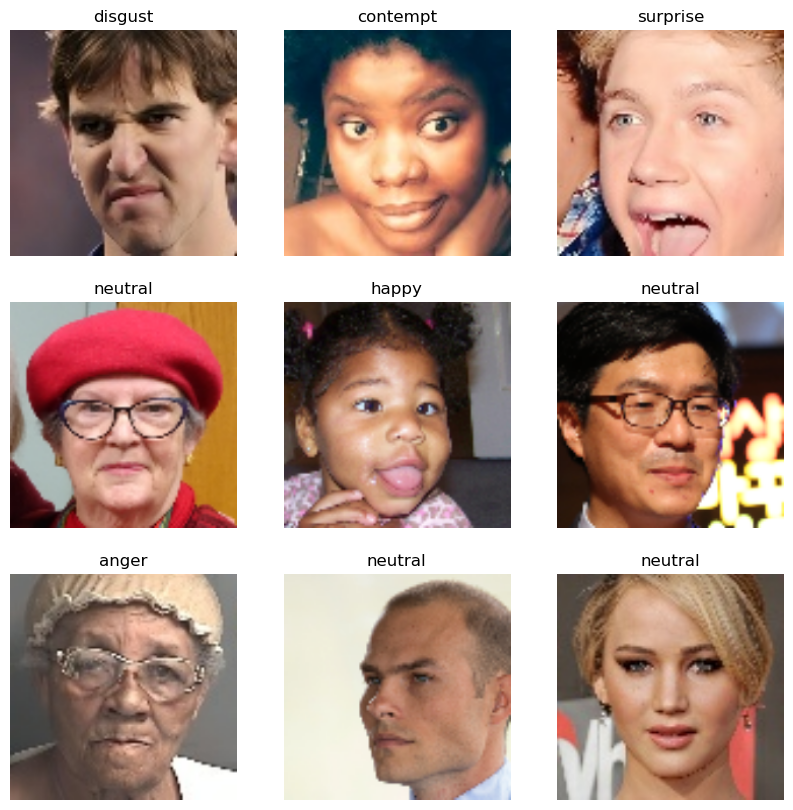

In [17]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Resizing, Rescaling



In [19]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_base.layers[:-4]:
    layer.trainable = False


In [20]:
# weights_path = 
# model_path = "D:\\model\\facenet_keras.h5"

In [21]:
# base_model = tf.keras.models.load_model('facenet_keras.h5')
# base_model.load_weights('facenet_keras_weights.h5')

In [23]:
# resnet_base.summary()

In [24]:
# last_layer = base_model.layers[-2].output

In [27]:
x = resnet_base.output
x = Flatten()(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs=resnet_base.input, outputs=predictions)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])



In [30]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds)


Epoch 1/30


E:\anaconda\envs\py310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


727/727 [==============================] - 130s 167ms/step - loss: 6.9914 - accuracy: 0.4745 - val_loss: 6.6160 - val_accuracy: 0.5200
Epoch 2/30
727/727 [==============================] - 119s 164ms/step - loss: 2.1827 - accuracy: 0.7727 - val_loss: 6.7467 - val_accuracy: 0.5576
Epoch 3/30
727/727 [==============================] - 119s 163ms/step - loss: 1.3717 - accuracy: 0.8557 - val_loss: 8.3592 - val_accuracy: 0.5430
Epoch 4/30
727/727 [==============================] - 119s 163ms/step - loss: 0.9636 - accuracy: 0.9005 - val_loss: 9.4381 - val_accuracy: 0.5395
Epoch 5/30
727/727 [==============================] - 119s 163ms/step - loss: 0.9354 - accuracy: 0.9147 - val_loss: 9.2962 - val_accuracy: 0.5610
Epoch 6/30
727/727 [==============================] - 118s 163ms/step - loss: 0.9484 - accuracy: 0.9206 - val_loss: 10.5508 - val_accuracy: 0.5483
Epoch 7/30
727/727 [==============================] - 119s 163ms/step - loss: 1.1036 - accuracy: 0.9208 - val_loss: 11.7868 - val_accu

In [ ]:
print(tf.config.list_physical_devices('GPU'))

In [ ]:
# len(train_ds.class_names)

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.plot(history['test_accuracy'], label='Test Accuracy')  # Add test accuracy curve
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()